In [3]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import argparse
import os
import imp
import re

from mimic3models.patient_embedding import utils
from mimic3benchmark.readers import DayReader

from mimic3models.preprocessing import DiscretizerContinuous, Normalizer
from mimic3models import common_utils

from mimic3models.pytorch_models.classification.dataset.utils import ClassificationDataset
from mimic3models.pytorch_models.classification.train.train import ClassificationTrainer

from torch.utils.data import DataLoader

import torch

from sklearn.manifold import TSNE

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import random

random.seed(49297)

In [7]:
data = '/home/neil.jethani/patient_embedding/data/in_hospital_mortality'
embed_method = 'DAE'
model_dir = '/home/neil.jethani/patient_embedding/models/patient_embedding/DAE/2019-08-05_16-00-17/DAE.ep45'

In [8]:
# Build readers, discretizers, normalizers
print("Creating Data File Reader")
train_reader = DayReader(dataset_dir=os.path.join(data, 'val'), 
                                         listfile=os.path.join(data, 'val', 'listfile.csv'), 
                                         period_length=24.0)

val_reader = DayReader(dataset_dir=os.path.join(data, 'val_test'),
                                       listfile=os.path.join(data, 'val_test', 'listfile.csv'),
                                       period_length=24.0)

print("Initializing Discretizer and Normalizer")
discretizer = DiscretizerContinuous(timestep=1.0,
                                    store_masks=False,
                                    impute_strategy='previous',
                                    start_time='zero')

discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1]
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

normalizer = Normalizer(fields=cont_channels)  # choose here which columns to standardize
normalizer_state = 'ptemb_ts{}.input_str:{}.start_time:zero.normalizer'.format(1.0, 'previous')
normalizer_state = os.path.join("/home/neil.jethani/patient_embedding/src/mimic3models/patient_embedding", normalizer_state)
normalizer.load_params(normalizer_state)

#Create Dataset + DataLoader
print("Building Dataset")
train_dataset = ClassificationDataset(reader=train_reader, discretizer=discretizer, 
                                           normalizer=normalizer, return_name=False, 
                                           embed_method=embed_method)
val_dataset = ClassificationDataset(reader=val_reader, discretizer=discretizer, 
                                         normalizer=normalizer, return_name=False, 
                                         embed_method=embed_method)

print("Building DataLoader")
trainLoader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

Creating Data File Reader
Initializing Discretizer and Normalizer
Building Dataset
Building DataLoader


In [78]:
model = torch.load(model_dir).float().to('cuda:1')

In [79]:
for i, data in enumerate(trainLoader):
    #data = data
    data = {key: value.float().to('cuda:1') for key, value in data.items()}
    x_emb, emb  = model(src=data['X'], src_mask=None)

In [149]:
torch.cat((x_emb, emb), dim=1).size()

torch.Size([13044, 204])

In [82]:
x_TRANS = emb.detach().cpu().numpy()

In [83]:
y_TRANS_IHM = data['y'].cpu().numpy()

In [66]:
y_TRANS_ELOS = data['y'].numpy()

In [163]:
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=300, learning_rate=50)
tsne_results_TRANS = tsne.fit_transform(x_TRANS)

In [164]:
tsne_df_TRANS = pd.DataFrame(tsne_results_TRANS)

In [165]:
tsne_df_TRANS['y_IHM'] = y_TRANS_IHM
tsne_df_TRANS.columns = ['0', '1', 'y_IHM']

In [67]:
tsne_df['y'] = y_ELOS

In [1]:
plt.figure(figsize=(16,10))
pal = ["#d9f0a3", "#800026"]
sns.set_palette(pal)
sns.lmplot(
    x='0', y='1',
    hue="y_IHM",
    #palette=sns.color_palette("YlGnBu", 2),
    data=tsne_df_TRANS,
    legend="full",
    alpha=0.3
)

NameError: name 'plt' is not defined

In [92]:
for i, data in enumerate(trainLoader):
    data = {key: value.float() for key, value in data.items()}

In [93]:
x_RAW = data['X'].numpy()
y_RAW_IHM = data['y'].numpy()

In [72]:
y_RAW_ELOS = data['y'].numpy()

In [108]:
tsne_RAW = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results_RAW = tsne_raw.fit_transform(x_RAW)

In [109]:
tsne_df_RAW = pd.DataFrame(tsne_results_RAW)
tsne_df_RAW['y_IHM'] = y_RAW_IHM
tsne_df_RAW.columns = ['0', '1', 'y_IHM']

In [110]:
tsne_df_RAW['y_ELOS'] = y_ELOS_raw

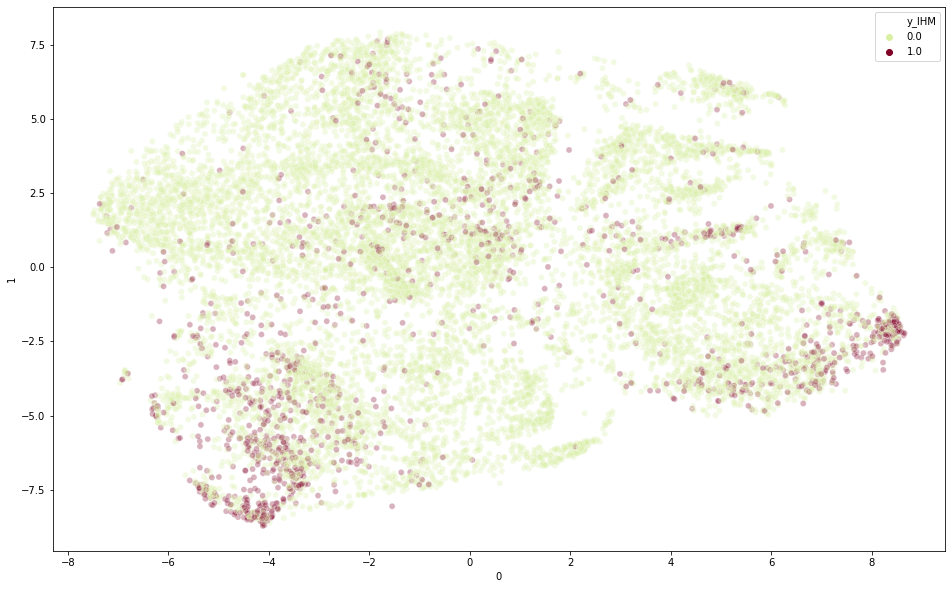

In [111]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='0', y='1',
    hue="y_IHM",
    #palette=sns.color_palette("hls", 2),
    data=tsne_df_RAW,
    legend="full",
    alpha=0.3
)

In [55]:
for i, data in enumerate(trainLoader):
    data = {key: value.float() for key, value in data.items()}

In [ ]:
x = emb.detach().cpu().numpy()
y = data['y'].cpu().numpy()

In [ ]:
tsne_raw = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results_raw = tsne_raw.fit_transform(x)

In [122]:
trash = torch.Tensor([0,1]).float()
type(trash)

torch.Tensor

In [121]:
torch.Tensor(trash)

tensor([0., 1.])

In [123]:
trash.dtype

torch.float32

In [9]:
model = torch.load(model_dir).float().to('cuda:1')
model.embed = True

In [10]:
for i, data in enumerate(trainLoader):
    #data = data
    data = {key: value.float().to('cuda:1') for key, value in data.items()}
    x_emb  = model(src=data['X'])

In [11]:
x_DAE = x_emb.detach().cpu().numpy()

In [12]:
y_DAE_IHM = data['y'].cpu().numpy()

In [66]:
y_DAE_ELOS = data['y'].numpy()

In [13]:
tsne_DAE = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=300)
tsne_results_DAE = tsne_DAE.fit_transform(x_DAE)

In [14]:
tsne_df_DAE = pd.DataFrame(tsne_results_DAE)

In [15]:
tsne_df_DAE['y_IHM'] = y_DAE_IHM
tsne_df_DAE.columns = ['0', '1', 'y_IHM']

In [34]:
tsne_df_DAE['y_IHM'] = tsne_df_DAE['y_IHM'].apply(lambda x: 'negative' if x==0.0 else 'positive')

In [67]:
tsne_df['y'] = y_ELOS

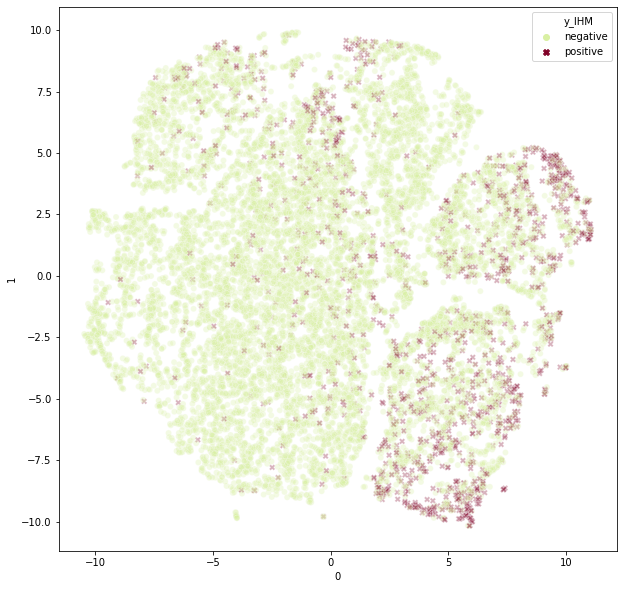

In [35]:
plt.figure(figsize=(10,10))
pal = ["#d9f0a3", "#800026"]
sns.set_palette(pal)
sns.scatterplot(
    x='0', y='1',
    hue="y_IHM",
    style = "y_IHM",
    #palette=sns.color_palette("YlGnBu", 2),
    data=tsne_df_DAE,
    legend="full",
    alpha = 0.3
)